# Sinus Function Approximation Experiment

This notebook trains a neural network to approximate a sine function 
under noise in both inputs and outputs. The code is refactored for clarity 
and easy configurability. You can change hyperparameters such as:
- Number of hidden layers
- Hidden layer width
- Learning rate
- Number of epochs
- Amount of noise in the inputs and outputs
- Data generation methods (linspace vs. random)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Hyperparameters & Configuration

In [2]:
# Data parameters
TOTAL_SIZE = 20000         # total number of data points
VAL_RATIO = 0.3          # fraction of data for validation
X_INTERVAL = 2           # multiplier for the range of x: [-2π, 2π]
HOW_TO_GENERATE = "linspace"  # or "random"
HOW_TO_SPLIT = "sequential"      # or "shuffled"

# Noise parameters
INPUT_NOISE_STD = 0.2    # standard deviation of noise added to x
OUTPUT_NOISE_STD = 0.1   # standard deviation of noise added to sin(x)

# Model architecture
NUM_INPUTS = 2           # we feed x only (or could feed x + noise as 2D input if you wish)
HIDDEN_LAYERS = 2        # how many hidden layers
HIDDEN_DIM = 32          # width of each hidden layer
ACTIVATION = nn.ReLU()   # activation function
NUM_OUTPUTS = 1

# Training parameters
NUM_EPOCHS = 400
LEARNING_RATE = 1e-2
BATCH_SIZE = 128

# Whether or not to use GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Generation

In [3]:
def generate_sin_data(
    total_size: int,
    val_ratio: float,
    x_interval: float,
    how: str = "linspace",
    input_noise_std: float = 0.0,
    output_noise_std: float = 0.0,
    split_method: str = "sequential"  # Options: "sequential" or "shuffled"
):
    """
    Generates (x, sin(x)) data, splits it into training and validation sets.
    Allows choice between sequential and shuffled splitting.
    
    Args:
        total_size (int): total number of data points.
        val_ratio (float): fraction of data used for validation.
        x_interval (float): the interval multiplier for x in [-x_interval*π, x_interval*π].
        how (str): "linspace" or "random"; method of generating x.
        input_noise_std (float): standard deviation for noise added to x.
        output_noise_std (float): standard deviation for noise added to sin(x).
        split_method (str): "sequential" for sequential split or "shuffled" for random split.

    Returns:
        (X_train, y_train, X_val, y_val):
            X_train: (N_train, 2) torch.Tensor
            y_train: (N_train,)   torch.Tensor
            X_val:   (N_val, 2)   torch.Tensor
            y_val:   (N_val,)     torch.Tensor
    """
    # Generate x
    if how.lower() == "linspace":
        x = np.linspace(-x_interval * np.pi, x_interval * np.pi, total_size)
    elif how.lower() == "random":
        x = np.random.uniform(-x_interval * np.pi, x_interval * np.pi, size=total_size)
    else:
        raise ValueError("Invalid generation method. Choose 'linspace' or 'random'.")

    # Add optional noise to x
    x_noise = np.random.normal(loc=0.0, scale=input_noise_std, size=total_size)
    
    # Generate output sin(x) with optional noise
    y_noise = np.random.normal(loc=0.0, scale=output_noise_std, size=total_size)
    y = np.sin(x) + y_noise

    # Convert to torch Tensors
    X = torch.tensor(np.stack([x, x_noise], axis=-1), dtype=torch.float32)
    Y = torch.tensor(y, dtype=torch.float32)

    # Split sizes
    val_size = int(val_ratio * total_size)
    train_size = total_size - val_size

    if split_method == "sequential":
        # Sequential split
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = Y[:train_size], Y[train_size:]
    elif split_method == "shuffled":
        # Shuffled split
        indices = torch.randperm(total_size)
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = Y[train_indices], Y[val_indices]
    else:
        raise ValueError("Invalid split_method. Choose 'sequential' or 'shuffled'.")

    return X_train, y_train, X_val, y_val

## Model Definition

In [4]:
class SinApproximator(nn.Module):
    """
    A simple feedforward neural network for approximating sin(x).
    """
    def __init__(self, 
                 num_inputs: int = 1, 
                 hidden_layers: int = 2, 
                 hidden_dim: int = 32, 
                 num_outputs: int = 1,
                 activation: nn.Module = nn.ReLU(),
                 activation_last: nn.Module = nn.Tanh()):
        super(SinApproximator, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(num_inputs, hidden_dim))
        layers.append(activation)

        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)

        # Output layer
        layers.append(nn.Linear(hidden_dim, num_outputs))
        #layers.append(activation_last)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Training Loop

In [5]:
import torch
import matplotlib.pyplot as plt


def plot_noise_weight_norms(noise_weight_norms):
    """
    Plots the L2 norm of the weights in the first layer
    that correspond to the second input dimension (noise) over epochs.

    Args:
        noise_weight_norms (list of float):
            The L2 norm of the noise-input weights, saved at each epoch.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(noise_weight_norms, label="Noise Weight Norm")
    plt.title("Evolution of Noise-Input Weights (First Layer)")
    plt.xlabel("Epoch")
    plt.ylabel("L2 Norm")
    plt.legend()
    plt.grid(True)
    plt.show()


def train_model(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    num_epochs: int,
    batch_size: int,
    lr: float,
    device: str = "cpu",
):
    """
    Trains the model on (X_train, y_train), validates on (X_val, y_val).

    Returns:
        (train_losses, val_losses, best_model_state, noise_weight_norms):
            train_losses: list of training MSE values over epochs
            val_losses:   list of validation MSE values over epochs
            best_model_state: a copy of the best model state_dict (lowest val loss)
            noise_weight_norms: L2 norm of the first-layer "noise" weights per epoch
    """
    # Move model & data to device
    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    # DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    # Loss & optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    noise_weight_norms = []  # <--- We'll store the norm here

    best_val_loss = float("inf")
    best_model_state = None

    for epoch in tqdm(range(num_epochs)):

        # --- Track the norm of the noise weights ---
        # Assume the first layer is model.net[0], which is nn.Linear(*, *),
        # and the second column (index 1) corresponds to the noise input.
        with torch.no_grad():
            first_layer = model.net[0]  # nn.Linear
            # shape of first_layer.weight = (hidden_dim, num_inputs)
            # we want the second column => [:, 1]
            noise_weights = first_layer.weight[1, :]
            noise_weight_norm = torch.norm(noise_weights, p=2).item()
            noise_weight_norms.append(noise_weight_norm)
            
        # --- Training ---
        model.train()
        epoch_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_X)
            loss = criterion(preds.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * batch_X.size(0)

        epoch_train_loss /= len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val).squeeze()
            val_loss = criterion(val_preds, y_val).item()

        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

        # Track best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}


        # Print progress every 500 epochs (optional)
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print(
                f"[Epoch {epoch+1}/{num_epochs}] "
                f"Train Loss: {epoch_train_loss:.6f} | Val Loss: {val_loss:.6f} "
                f"| Noise Weights Norm: {noise_weight_norm:.6f}"
            )

    return train_losses, val_losses, best_model_state, noise_weight_norms

## Running the Experiment
1) Generate data

In [6]:
X_train, y_train, X_val, y_val = generate_sin_data(
    total_size=TOTAL_SIZE,
    val_ratio=VAL_RATIO,
    x_interval=X_INTERVAL,
    how=HOW_TO_GENERATE,
    input_noise_std=INPUT_NOISE_STD,
    output_noise_std=OUTPUT_NOISE_STD
)

2) Create the model

In [7]:
model = SinApproximator(
    num_inputs=NUM_INPUTS,
    hidden_layers=HIDDEN_LAYERS,
    hidden_dim=HIDDEN_DIM,
    num_outputs=NUM_OUTPUTS,
    activation=ACTIVATION
)

3) Train the model

In [8]:
train_losses, val_losses, best_state, noise_weight_norms = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    device=DEVICE
)


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 1/400] Train Loss: 0.101873 | Val Loss: 0.425826 | Noise Weights Norm: 0.670347
[Epoch 10/400] Train Loss: 0.011341 | Val Loss: 0.275795 | Noise Weights Norm: 0.382751
[Epoch 20/400] Train Loss: 0.011026 | Val Loss: 0.230698 | Noise Weights Norm: 0.269133
[Epoch 30/400] Train Loss: 0.011097 | Val Loss: 0.741631 | Noise Weights Norm: 0.181880
[Epoch 40/400] Train Loss: 0.010938 | Val Loss: 1.118008 | Noise Weights Norm: 0.212140
[Epoch 50/400] Train Loss: 0.011243 | Val Loss: 1.295758 | Noise Weights Norm: 0.093241
[Epoch 60/400] Train Loss: 0.011149 | Val Loss: 1.393954 | Noise Weights Norm: 0.093241
[Epoch 70/400] Train Loss: 0.010796 | Val Loss: 1.367637 | Noise Weights Norm: 0.093241
[Epoch 80/400] Train Loss: 0.010972 | Val Loss: 1.487214 | Noise Weights Norm: 0.093241
[Epoch 90/400] Train Loss: 0.011227 | Val Loss: 1.496430 | Noise Weights Norm: 0.093241
[Epoch 100/400] Train Loss: 0.010958 | Val Loss: 1.476417 | Noise Weights Norm: 0.093241
[Epoch 110/400] Train Loss: 0.01

## Evaluation & Plots

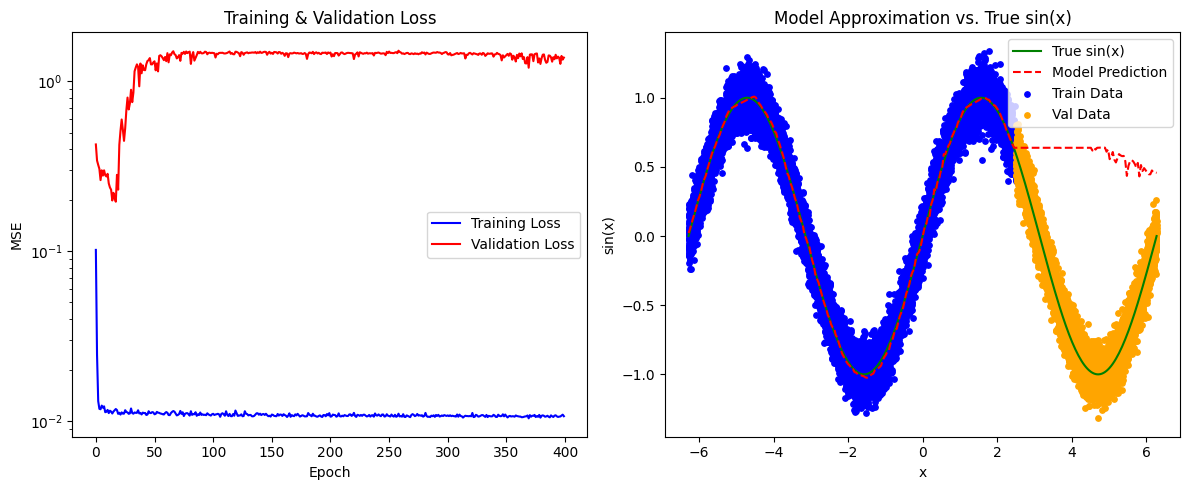

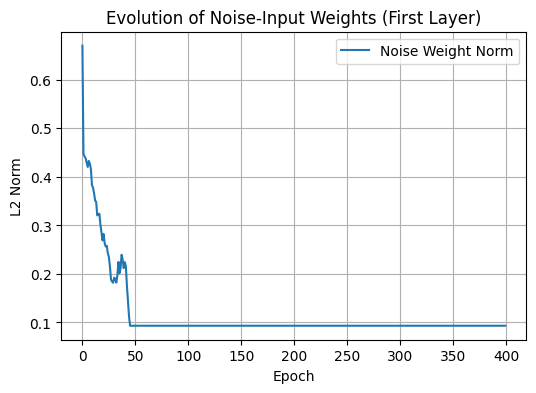

In [9]:
model.load_state_dict(best_state)


def plot_results(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    train_losses: list,
    val_losses: list,
    device: str = "cpu",
):
    """
    Makes plots of:
      - Predicted vs. true sin(x) for a dense range of x
      - Training vs. Validation losses (MSE) over epochs
      - Training vs. Validation points

    Args:
        model (nn.Module): trained model
        X_train (torch.Tensor): training inputs
        y_train (torch.Tensor): training targets
        X_val (torch.Tensor): validation inputs
        y_val (torch.Tensor): validation targets
        train_losses (list): training MSE over epochs
        val_losses (list): validation MSE over epochs
        device (str): "cpu" or "cuda"
    """
    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 1) Plot training & validation losses
    axs[0].plot(train_losses, label="Training Loss", color="blue")
    axs[0].plot(val_losses, label="Validation Loss", color="red")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("MSE")
    axs[0].set_title("Training & Validation Loss")
    axs[0].legend()
    axs[0].set_yscale("log")  # optional

    # 2) Plot predictions vs. ground truth
    #    We'll create a dense array of x for smooth plotting
    x_plot = np.linspace(-X_INTERVAL * np.pi, X_INTERVAL * np.pi, 300)
    x_plot_noise = np.random.normal(loc=0.0, scale=INPUT_NOISE_STD, size=x_plot.shape)
    x_plot_t = torch.tensor(
        np.stack(
            [
                x_plot,
                x_plot_noise,
            ],
            axis=-1,
        ),
        dtype=torch.float32,
    ).to(device)

    model.eval()
    with torch.no_grad():
        preds_plot = model(x_plot_t).squeeze().cpu().numpy()

    # True sine
    sine_plot = np.sin(x_plot)

    # Plot them
    axs[1].plot(x_plot, sine_plot, label="True sin(x)", color="green")
    axs[1].plot(
        x_plot,
        preds_plot,
        label="Model Prediction",
        color="red",
        linestyle="--",
    )

    # Also show the training and validation data points
    axs[1].scatter(
        X_train.cpu().numpy()[:, 0],
        y_train.cpu().numpy(),
        label="Train Data",
        color="blue",
        s=15,
    )
    axs[1].scatter(
        X_val.cpu().numpy()[:, 0],
        y_val.cpu().numpy(),
        label="Val Data",
        color="orange",
        s=15,
    )

    axs[1].set_xlabel("x")
    axs[1].set_ylabel("sin(x)")
    axs[1].set_title("Model Approximation vs. True sin(x)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_results(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    train_losses,
    val_losses,
    device=DEVICE,
)

plot_noise_weight_norms(noise_weight_norms)
